<a href="https://colab.research.google.com/github/areias/slm-finetunig/blob/main/finetune_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-tuning Mistral-7b for relationship extraction

See how mistral-7b performs at relationship extraction task before and after fine-tuning on 1000 examples.

based on

[Fine-tune large models using 🤗 peft adapters, transformers & bitsandbytes](https://colab.research.google.com/drive/1jCkpikz0J2o20FBQmYmAGdiKmJGOMo-o?usp=sharing#scrollTo=WE5GJ6s7y0Xo)


[transformers meets bitsandbytes for democratzing Large Language Models (LLMs) through 4bit quantization](https://colab.research.google.com/drive/1VoYNfYDKcKRQRor98Zbf2-9VQTtGJ24k#scrollTo=jq0nX33BmfaC)

[Fine-tuning Mistral on your own data](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb)

[Fine-tuning Large Language Models](https://learn.deeplearning.ai/finetuning-large-language-models/lesson/1/introduction)


[Ollama: Running GGUF Models from Hugging Face](https://www.markhneedham.com/blog/2023/10/18/ollama-hugging-face-gguf-models/)





## Load our fine-tuning data

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! ls drive/MyDrive/mistral-finetune/data

nyt10m_finetuning.csv  nyt10m_test.csv


In [ ]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/mistral-finetune/data/nyt10m_finetuning.csv")

In [ ]:
len(df['text'].unique())

1000

In [ ]:
df.head()

,text,h_name,t_name,relation
0,Political opponents of President Evo Morales o...,Evo Morales,Bolivia,/people/person/nationality
1,Political opponents of President Evo Morales o...,Evo Morales,Bolivia,/people/person/place_lived
2,"I am certain that on May 1 , comrade Fidel wil...",Evo Morales,Bolivia,/people/person/nationality
3,-LRB- Dave Kehr -RRB- FARES TO REMEMBER : TAXI...,New York City,IFC Center,NaN
4,At least 11 families will be immediately affec...,Selena Fox,Wisconsin,/people/person/place_lived


In [ ]:
df.loc[df['relation'].isna(),'relation']="None"

In [ ]:
sentence=df['text'].unique()[31]
sentence

"We should be very careful about encouraging the creation of new dividing lines in Europe or the return of an old order , '' President Jacques Chirac of France said last month when asked about the American antimissile missile plans ."

In [ ]:
df.relation.value_counts() / len(df)

/location/located_in                          0.275373
None                                          0.247015
/people/person/place_lived                    0.194030
/location/country/administrative_divisions    0.072388
/business/person/company                      0.065672
/people/person/nationality                    0.063433
/location/administrative_division/country     0.044776
/business/location                            0.011940
/business/company/advisors                    0.011194
/people/person/place_of_birth                 0.008955
/people/deceasedperson/place_of_death         0.005224
Name: relation, dtype: float64

In [ ]:
df[df['text']==sentence]

,text,h_name,t_name,relation
47,We should be very careful about encouraging th...,Jacques Chirac,France,/people/person/nationality
48,We should be very careful about encouraging th...,Jacques Chirac,France,/people/person/place_lived


In [ ]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [ ]:
import numpy as np
from helper_functions import preprocess

In [ ]:
# make sure works for example with no relations
data = preprocess(df)
data[400]

{'input': "I do n't think he understands the word no , '' said John Lango , the coach at Gavilan College in Gilroy , Calif. , Garcia 's home town , and an assistant coach for a season during Garcia 's days at Gilroy High . ''",
 'output': 'None'}

In [ ]:
# and exapmle with multiple relations
data[230]

{'input': 'Last year at the World Economic Forum in Davos , Switzerland , officials suggested there was great opportunity for personal trainers , people who can keep the rich looking fit and thin .',
 'output': "('Davos', '/location/located_in', 'Switzerland'), ('Switzerland', '/location/country/administrative_divisions', 'Davos')"}

In [ ]:
# as well as your single relation
data[3]

{'input': "At least 11 families will be immediately affected by the V.A. 's decision , said the Rev. Selena Fox , senior minister of Circle Sanctuary , a Wiccan church in Wisconsin .",
 'output': "('Selena Fox', '/people/person/place_lived', 'Wisconsin')"}

In [ ]:
df.relation.value_counts(dropna=False)

/location/located_in                          369
None                                          331
/people/person/place_lived                    260
/location/country/administrative_divisions     97
/business/person/company                       88
/people/person/nationality                     85
/location/administrative_division/country      60
/business/location                             16
/business/company/advisors                     15
/people/person/place_of_birth                  12
/people/deceasedperson/place_of_death           7
Name: relation, dtype: int64

In [ ]:
relations = np.sort(list(df.relation.unique()))
relations = list(relations[:len(relations)-1])
relations


['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']

In [ ]:
from helper_functions import formatting_func

In [ ]:
print(formatting_func(data[0]))

[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] 
What relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!
The given sentence is: 'Political opponents of President Evo Morales of Bolivia have in recent days stepped up criticism of the country 's strengthening military relationship with Venezuela after Bolivian officials acknowledged that more than two dozen uniformed members of the Venezuelan military had recently entered the country without congressional approval .'
If none present, answer: None.
Respond with relationship 

In [ ]:
! pip install -q peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.5 MB/s eta 0:00:00


In [ ]:
pip install -q git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
! pip install -q bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.4 MB/s eta 0:00:00


In [ ]:
! pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


## Load a quantized Mistral:instruct model

https://huggingface.co/docs/peft/main/en/developer_guides/quantization


...since PEFT methods only add extra trainable parameters, this allows you to train a quantized model with a PEFT adapter on top! Combining quantization with PEFT can be a good strategy for training even the largest models on a single GPU. For example, QLoRA is a method that quantizes a model to 4-bits and then trains it with LoRA.


bitsandbytes is a quantization library with a Transformers integration. With this integration, you can quantize a model to 8 or 4-bits and enable many other options by configuring the BitsAndBytesConfig class. For example, you can:

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

 https://huggingface.co/docs/peft/main/en/developer_guides/quantization

...For example, you can:

* set load_in_4bit=True to quantize the model to 4-bits when you load it
* set bnb_4bit_quant_type="nf4" to use a special 4-bit data type for weights initialized from a normal distribution
* set bnb_4bit_use_double_quant=True to use a nested quantization scheme to quantize the already quantized weights
* set bnb_4bit_compute_dtype=torch.bfloat16 to use bfloat16 for faster computation

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


Pass the config to the from_pretrained method.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Load tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                        padding_side="left") # padding on left from brewdev notebook
tokenizer.pad_token = tokenizer.eos_token




Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what self-supervised fine-tuning is.


In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

## Evaluate model out of the box



In [ ]:
from helper_functions import get_relations, get_tuples, get_scores

In [ ]:
eval_prompt = formatting_func(data[230])
print(eval_prompt)

[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] 
What relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!
The given sentence is: 'Last year at the World Economic Forum in Davos , Switzerland , officials suggested there was great opportunity for personal trainers , people who can keep the rich looking fit and thin .'
If none present, answer: None.
Respond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), (head entity 2, relation 2, tail entity 2), (...) 
Take care, your answer is only valid if it f

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)


In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response  = eval_tokenizer.decode(model.generate(**model_input,
                    max_new_tokens=256, repetition_penalty=1.15,
                    pad_token_id=eval_tokenizer.eos_token_id)[0], skip_special_tokens=True)
    response = response.replace(eval_prompt, "")
    print(response)

 Based on the given sentence, the following relation might be present:
(/business/event, /location/country, Switzerland)
Therefore, the relation triple would be: (World Economic Forum, location, Switzerland).


In [ ]:
predicted_relations = get_tuples(response.replace(eval_prompt, ""))
predicted_relations

[('/business/event', '/location/country', 'Switzerland'),
 ('World Economic Forum', 'location', 'Switzerland')]

In [ ]:
#predicted_relations.append(('Evo Morales', '/people/person/nationality', 'Bolivia'))

In [ ]:
#predicted_relations

In [ ]:
import helper_functions
from importlib import reload
reload(helper_functions)

<module 'helper_functions' from '/content/drive/My Drive/mistral-finetune/helper_functions.py'>

In [ ]:
expected_relations =helper_functions.get_relations(data[400])
expected_relations

['None']

In [ ]:
get_scores(expected_relations, ["None"])

(1.0, 1.0, 1.0)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
pip install pyarrow==11.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.0
    Uninstalling pyarrow-15.0.0:
      Successfully uninstalled pyarrow-15.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.17.1 requires pyarrow>=12.0.0, but you have pyarrow 11.0.0 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Split DataFrame into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert back to datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)



In [ ]:
# Optionally, you can remove the pandas index column
train_dataset = train_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')



In [ ]:
train_dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 800
})

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]['input_ids'])

"<s> [INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] \nWhat relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!\nThe given sentence is: 'A5 NATIONAL A9-11 ; 14 Guantánamo Detainees Rebuff Their Lawyers Many of the detainees at Guantánamo Bay , Cuba , are no longer cooperating with their lawyers , adding a largely invisible struggle between the lawyers and their own clients to the legal battle over the administration 's detention policies .'\nIf none present, answer: None.\nRespond with relationship triples, e.g. (head enti

In [ ]:
len(tokenized_train_dataset[1]['input_ids'])

309

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 733, 16289, 28793, 995, 460, 396, 418, 11661, 7583, 3638, 286, 395, 9040, 304, 9378, 9237, 1774, 28723, 4003, 349, 264, 1274, 302, 4628, 9378, 4514, 28747, 5936, 28748, 25443, 28748, 17998, 28748, 316, 3225, 734, 647, 7377, 25443, 28748, 2733, 647, 7377, 25443, 28748, 9701, 28748, 17998, 647, 7377, 2733, 28748, 28181, 1197, 28730, 1538, 1522, 28748, 16912, 647, 7377, 2733, 28748, 16912, 28748, 28181, 1197, 28730, 1538, 5662, 647, 7377, 2733, 28748, 1614, 601, 28730, 262, 647, 7377, 21721, 28748, 450, 358, 1293, 9701, 28748, 2912, 28730, 1009, 28730, 450, 498, 647, 7377, 21721, 28748, 9701, 28748, 28711, 1249, 472, 647, 7377, 21721, 28748, 9701, 28748, 2912, 28730, 28714, 1975, 647, 7377, 21721, 28748, 9701, 28748, 2912, 28730, 1009, 28730, 28726, 4633, 1421, 28705, 13, 3195, 3136, 297, 272, 2078, 1274, 1659, 347, 4658, 297, 272, 2078, 12271, 28804, 6746, 1864, 298, 938, 865, 3136, 477, 272, 1274, 3857, 28808, 13, 1014, 2078, 12271, 349, 28747, 464, 28741, 28782, 418, 4866, 1086, 33

1000


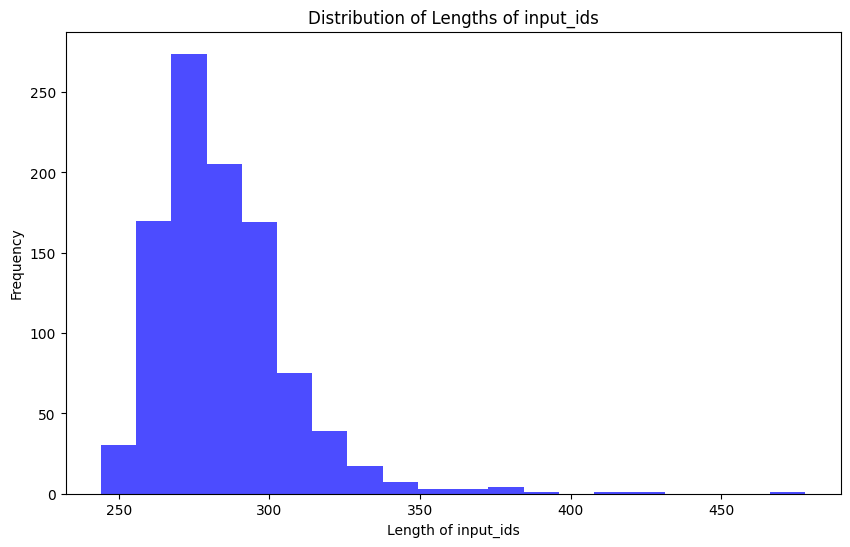

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_test_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset)

## Set up LoRA

Next, you should call the prepare_model_for_kbit_training() function to preprocess the quantized model for traininng.

In [ ]:
from peft import prepare_model_for_kbit_training

#model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

https://huggingface.co/docs/peft/main/en/developer_guides/lora#qlora-style-training

However, in QLoRA, it was found that adding trainable weights to all the linear layers of a transformer model is beneficial to match full-finetuning performance. Since the list of modules to add will vary depending on the architecture, we provided a convenient shorthand : simple specify target_modules='all-linear' and let 🤗PEFT handle the rest:

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules="all-linear",
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )



Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.


In [ ]:
model = get_peft_model(model, config)

https://github.com/huggingface/transformers/blob/main/src/transformers/models/mistral/modeling_mistral.py

In [ ]:
print_trainable_parameters(model)

trainable params: 83886080 || all params: 3835957248 || trainable%: 2.186835633888691


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

https://huggingface.co/docs/transformers/peft

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "mistral-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
! ls drive/MyDrive/mistral-finetune/

checkpoint-500	helper_functions.py	       mistral-finetuning-data.json
data		mistral-finetuning-data2.json  __pycache__


In [ ]:
#mkdir drive/MyDrive/mistral-finetune/runs

In [ ]:
#mkdir drive/MyDrive/mistral-finetune/runs/logs

In [ ]:

project = "relation-extraction-finetune"
base_model_name = "mistral7b"
run_name = base_model_name + "-" + project + "_2"
output_dir = "drive/MyDrive/mistral-finetune/runs/" + run_name


https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft



In [ ]:
output_dir

'drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_2'

bf16 gives error ValueError: Your setup doesn't support bf16/gpu. You need torch>=1.10, using Ampere GPU with cuda>=11.0

In [ ]:
from datetime import datetime
import transformers

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="drive/MyDrive/mistral-finetune/runs/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


wandb: Currently logged in as: aareias. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.935400,0.460710
50,0.424500,0.438463
75,0.428400,0.426325
100,0.395400,0.412679
125,0.375900,0.404806
150,0.428300,0.403185
175,0.378000,0.403086


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: 

In [ ]:

trainer.save_model("drive/MyDrive/mistral-finetuning/runs/mistral7b-relation-extraction-finetune_2/model")


restart session!

## Evaluating

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [ ]:
from helper_functions import preprocess

In [ ]:
# load test data
import pandas as pd
df = pd.read_csv("./drive/MyDrive/mistral-finetune/data/nyt10m_test.csv")


In [ ]:
df.loc[df['relation'].isna(),'relation']="None"

In [ ]:
data = preprocess(df)

In [ ]:
len(data)

100

In [ ]:
data[2]

{'input': 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .',
 'output': "('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')"}

In [ ]:
import numpy as np
relations = np.sort(list(df.relation.unique()))
relations = list(relations[:len(relations)-1])
relations

['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']

In [ ]:
""" double checking that fits training data same categories
['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']"""

" double checking that fits training data same categories\n['/business/company/advisors',\n '/business/location',\n '/business/person/company',\n '/location/administrative_division/country',\n '/location/country/administrative_divisions',\n '/location/located_in',\n '/people/deceasedperson/place_of_death',\n '/people/person/nationality',\n '/people/person/place_lived',\n '/people/person/place_of_birth']"

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
pip install accelerate

ERROR: Operation cancelled by user


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
eval_prompt = formatting_func(data[2])


In [ ]:
eval_prompt

"[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] \nWhat relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!\nThe given sentence is: 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .'\nIf none present, answer: None.\nRespond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), 

In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response  = eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)
    response = response.replace(eval_prompt, "")
    print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Based on the given sentence, the following relation triple can be extracted:
(Mstislav Rostropovich, /people/person/place_lived, Paris)


In [ ]:
predicted_relations = get_tuples(response)
predicted_relations

[('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')]

In [ ]:
expected_relations = get_relations(data[10])
expected_relations

['None']

In [ ]:
expected_set = set(expected_relations)
expected_set

{'None'}

In [ ]:
precision, recall,f1 = get_scores(expected_relations, predicted_relations)

In [ ]:
precision,recall,f1

(1.0, 1.0, 1.0)

In [ ]:
data[0].update({'base_model' : {'predicted_relations':predicted_relations,
                                'precision': precision,
                                'recall': recall,
                                'f1': f1}})

In [ ]:
data[1:3]

[{'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he literally goes to the birds -- and finds meaning in his life -- by taking up with a flock of wild red and green parrots .",
  'output': "('Mark Bittner', '/people/person/place_lived', 'San Francisco')"},
 {'input': 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .',
  'output': "('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')"}]

In [ ]:
list(range(1,3))

[1, 2]

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(total=len(data), desc='Progress')

for idx, example in zip(list(range(len(data))), data):

    eval_prompt = formatting_func(example)

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256,
                                                         repetition_penalty=1.15,
                                                         pad_token_id=eval_tokenizer.eos_token_id)[0],
                                          skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    predicted_relations = get_tuples(response)

    expected_relations = get_relations(example)

    precision, recall,f1 = get_scores(expected_relations, predicted_relations)

    data[idx].update({'base_model':
                        {'response': response,
                         'predicted_relations':predicted_relations,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1}
                    })
    progress_bar.update(1)

progress_bar.close()

Progress: 100%|██████████| 100/100 [22:17<00:00, 13.38s/it]


In [ ]:
data[:4]

[{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
  'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
  'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
   'predicted_relations': 'None',
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0}},
 {'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he l

In [ ]:
import json
# Define the file path
file_path = "./mistral-finetuning-data.json"

# Save the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

print(f"Data saved to {file_path}")


Data saved to ./mistral-finetuning-data.json


In [ ]:
# Calculate average metrics
avg_precision, avg_recall, avg_f1 = calculate_average_metrics(data)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


KeyError: 'base_model'

## load finetuned model

In [ ]:
! ls drive/MyDrive/mistral-finetune/checkpoint-500

adapter_config.json	   optimizer.pt  rng_state.pth	trainer_state.json
adapter_model.safetensors  README.md	 scheduler.pt	training_args.bin


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_id, add_bos_token=True, trust_remote_code=True)


In [ ]:
!ls drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_2


checkpoint-100	checkpoint-150	checkpoint-25  checkpoint-75
checkpoint-125	checkpoint-175	checkpoint-50


In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_2/checkpoint-175")


In [ ]:
import json
with open("drive/MyDrive/mistral-finetune/mistral-finetuning-data.json", "r") as json_file:
    data = json.load(json_file)

In [ ]:
data[:3]

[{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
  'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
  'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
   'predicted_relations': 'None',
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0}},
 {'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he l

In [ ]:
from helper_functions import formatting_func, get_tuples, get_relations, get_scores

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(total=len(data), desc='Progress')

for idx, example in zip(list(range(len(data))), data):

    eval_prompt = formatting_func(example)

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    ft_model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256,
                                                         repetition_penalty=1.15,
                                                         pad_token_id=eval_tokenizer.eos_token_id)[0],
                                          skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    predicted_relations = get_tuples(response)

    expected_relations = get_relations(example)

    precision, recall,f1 = get_scores(expected_relations, predicted_relations)

    data[idx].update({'ft_model':
                        {'response': response,
                         'predicted_relations':predicted_relations,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1}
                    })
    progress_bar.update(1)

progress_bar.close()

Progress: 100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


In [ ]:
data[3]

{'input': 'About 2.4 million people live within a 10-mile radius of the Westfield Garden State Plaza in Paramus , which is the largest shopping mall in the state and draws 20 million visitors a year .',
 'output': 'None',
 'base_model': {'response': " Based on the given sentence, the following relation triple can be extracted: ('Westfield Garden State Plaza', '/location/located_in', 'Paramus')",
  'predicted_relations': [['Westfield Garden State Plaza',
    '/location/located_in',
    'Paramus']],
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0},
 'ft_model': {'response': ' None.',
  'predicted_relations': ['None'],
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0}}

In [ ]:
# Define the file path
file_path = "drive/MyDrive/mistral-finetune/mistral-finetuning-data3.json"

# Save the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

print(f"Data saved to {file_path}")


Data saved to drive/MyDrive/mistral-finetune/mistral-finetuning-data3.json


In [ ]:
for idx, entry in enumerate(data):
    if entry['output']=="None":
        print(idx)
        break

3


In [ ]:
total_precision = 0.0
total_recall = 0.0
total_f1 = 0.0
total_samples = len(data)

for item in data:
    total_precision += item['ft_model']['precision']
    total_recall += item['ft_model']['recall']
    total_f1 += item['ft_model']['f1']

In [ ]:
for idx, item in enumerate(data):
    if item['ft_model']['precision']==1:
        print(idx)

3
4
10
19
20
33
36
45
51
56
59
64
66
67
69
73
75
78
80
83
87
94
95


In [ ]:
[x for x in data if (x['output'] == "None" and x['base_model']['predicted_relations'] == "None")]


[{'input': 'As the new face of the L.P.G.A. Tour , and as a star in Mexico and elsewhere , Ochoa seems to have taken to the job of being a role model .',
  'output': 'None',
  'base_model': {'response': ' Based on the given sentence, there do not seem to be any explicit relations mentioned that can be extracted using the provided list. Therefore, the answer would be: None.',
   'predicted_relations': 'None',
   'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0},
  'ft_model': {'response': ' None.',
   'predicted_relations': ['None'],
   'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0}},
 {'input': "Coincidentally , the movie Mr. Starkweather inspired , Terrence Malick 's '' Badlands , '' involves a flight to Saskatchewan .",
  'output': 'None',
  'base_model': {'response': " Based on the given sentence, there doesn't seem to be any clear-cut relation that can be extracted using the entities and relation types provided in the list. Therefore, the answer would be: None.",
   'predicted_r

In [ ]:
[item['ft_model']['predicted_relations'] for item in data]

[['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],
 ['None'],

In [ ]:
def calculate_average_metrics2(data):
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    total_samples = len(data)

    for item in data:
        total_precision += item['ft_model']['precision']
        total_recall += item['ft_model']['recall']
        total_f1 += item['ft_model']['f1']

    average_precision = total_precision / total_samples
    average_recall = total_recall / total_samples
    average_f1 = total_f1 / total_samples

    return average_precision, average_recall, average_f1

# Calculate average metrics
avg_precision, avg_recall, avg_f1 = calculate_average_metrics2(data)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


Average Precision: 0.23
Average Recall: 0.23
Average F1-score: 0.23


In [ ]:
data[24]['base_model']

{'response': ' None.\nIn this sentence, there are no explicit mentions of companies, locations, or people with specified relationships using the provided relation types. The sentence primarily discusses monetary amounts, political actions, and geographical references without specifying entities in a relational context according to the given relation types.',
 'predicted_relations': 'None',
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0}

In [ ]:
data[24]['ft_model']

{'response': ' None.\nIn this sentence, there are no explicit mentions of companies, locations, or people with specified relationships using the provided relation types. The sentence primarily discusses monetary amounts, political actions, and geographical references without specifying entities in a relational context according to the given relation types.',
 'predicted_relations': 'None',
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0}

In [ ]:
data[0]

{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
 'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
 'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
  'predicted_relations': 'None',
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0},
 'ft_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. Th